# To test the output of the GUI

# num_qubits = 1, dim_x = 1, dim_alpha =1-2; Rz(alpha) vs Rz(alpha)Rz(-alpha)Rz(alpha)

## Rz(alpha) part 1 output

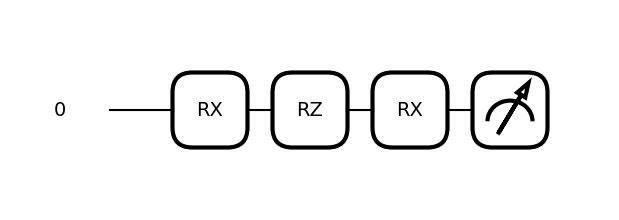

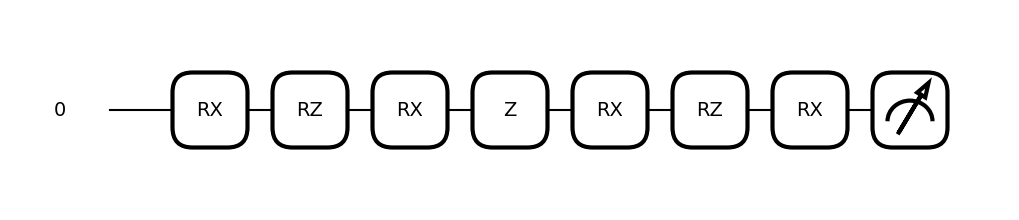

In [1]:
import pennylane as qml
import numpy as np

dim_x = 1
dim_alpha = 1
observable_terms = ['Z0']

def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def U(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[0], wires=0)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[0], wires=0)
    P = build_P(observable_terms)
    qml.RX(-x[0], wires=0)
    qml.RZ(-α[0], wires=0)
    qml.RX(-x[0], wires=0)
    return qml.state()

x0 = np.zeros(dim_x)
α0 = np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0);
qml.draw_mpl(UPU)(x0, α0);


## Rz(alpha) part 2 output

(0, 0)
  total shots:     10000
  kept shots:      10000
  fraction kept:   1.000000
  expectation:     1.0

(0, 1)
  total shots:     10000
  kept shots:      7004
  fraction kept:   0.700400
  expectation:     0.1736150770988007

(0, 2)
  total shots:     10000
  kept shots:      7190
  fraction kept:   0.719000
  expectation:     0.819749652294854

(1, 0)
  total shots:     10000
  kept shots:      7015
  fraction kept:   0.701500
  expectation:     0.19515324305060586

(1, 1)
  total shots:     10000
  kept shots:      3955
  fraction kept:   0.395500
  expectation:     1.0

(1, 2)
  total shots:     10000
  kept shots:      4126
  fraction kept:   0.412600
  expectation:     0.6233640329617063

(2, 0)
  total shots:     10000
  kept shots:      7027
  fraction kept:   0.702700
  expectation:     0.8127223566244486

(2, 1)
  total shots:     10000
  kept shots:      4147
  fraction kept:   0.414700
  expectation:     0.6040511212925006

(2, 2)
  total shots:     10000
  kept shots:

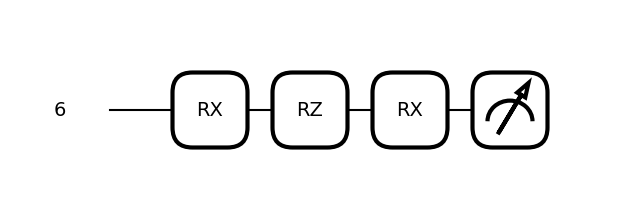

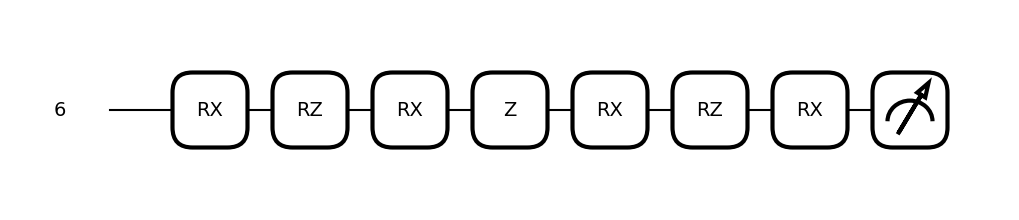

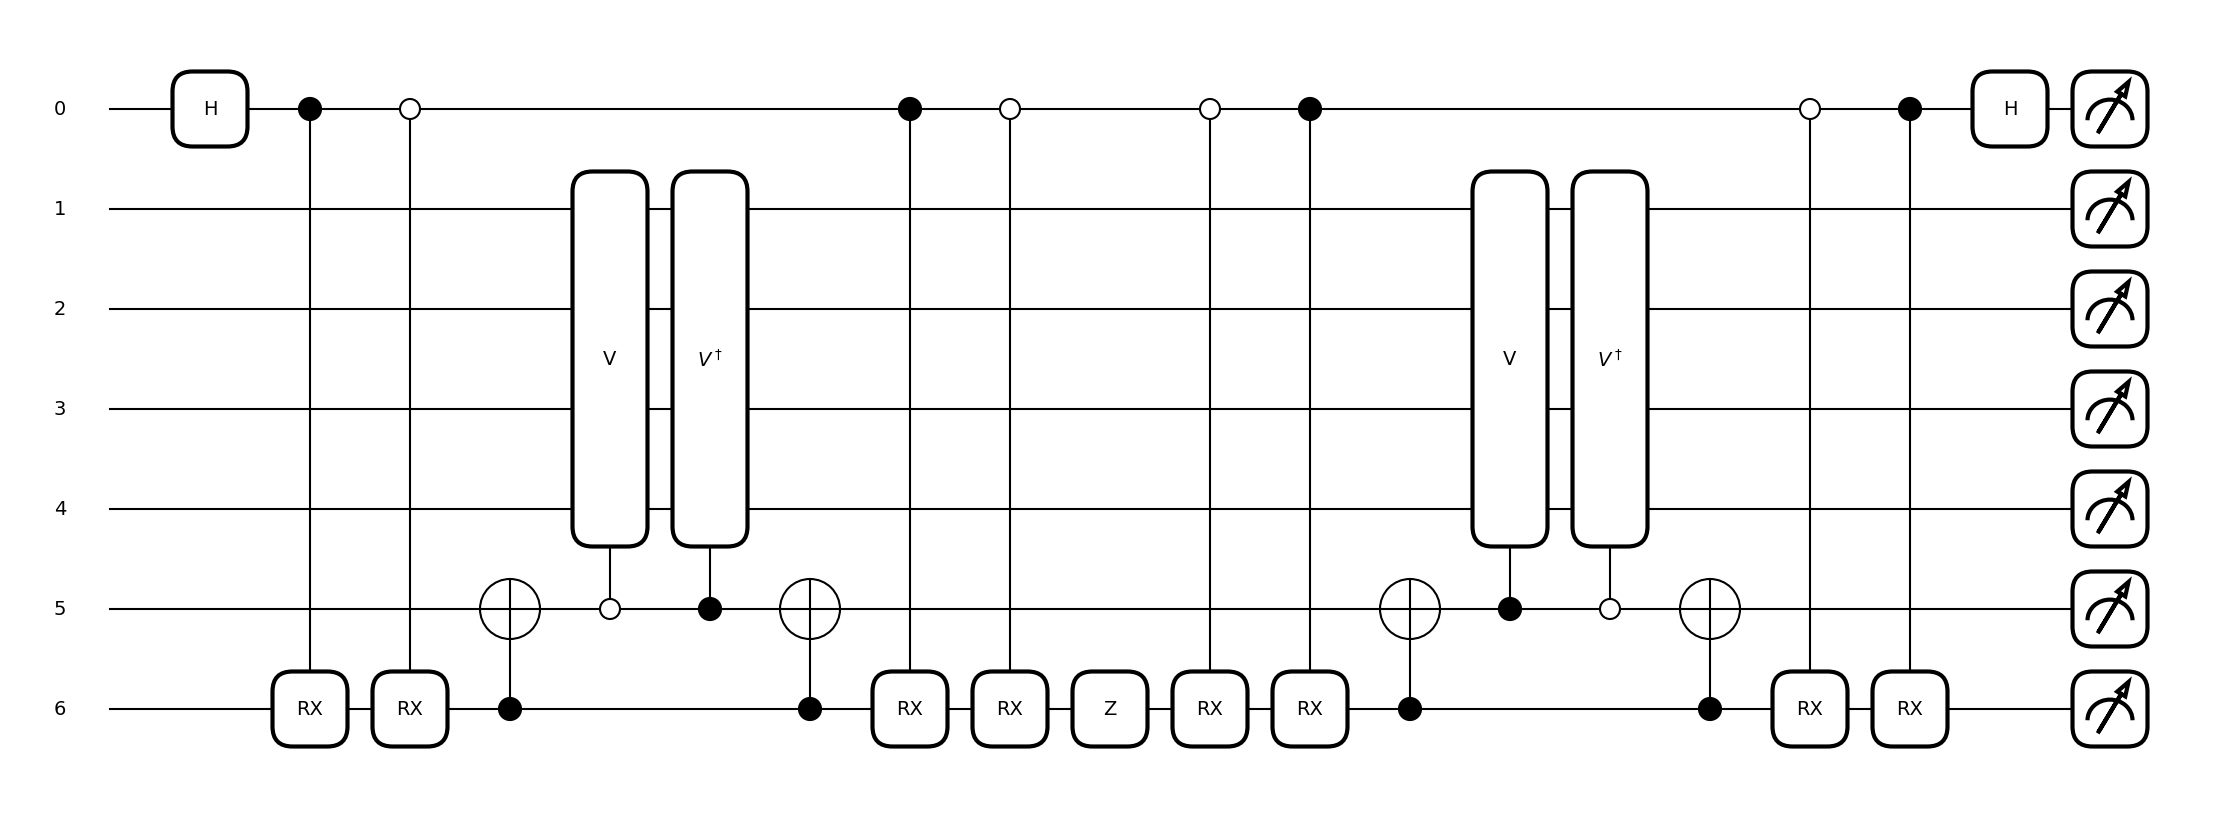

In [5]:
import pennylane as qml
import numpy as np


# Wrapper gates for controlled Adders
class V(qml.operation.Operation):
    num_params = 2
    par_domain = "R"
    def __init__(self, value, wires, mod):
        super().__init__(value, mod, wires=wires)


    def decomposition(self):
        # Actual gate: controlled Adder
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]

# Adjoint version
class Vdagger(V):
    def __name__(self):
        return "V†"

    def decomposition(self):
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]
Vdagger.__name__ = r"$V^\dagger$"

dim_x=1
dim_alpha=1
observable_terms=['Z0']

# build_P function
def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

n_kernel=1; freq_register_sizes={0: 4}; n_freq=4
n_anc=1; n_circ=1; n_total=7
kernel_offset=0; freq_offset=1
anc_offset=5; circ_offset=6
shots = 10000

dev=qml.device('default.qubit', wires=n_total, shots = shots)

@qml.qnode(dev)
def U(x, α):
    qml.RX(x[0], wires=6)
    qml.RZ(α[0], wires=6)
    qml.RX(x[0], wires=6)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=6)
    qml.RZ(α[0], wires=6)
    qml.RX(x[0], wires=6)
    # build P on shifted observables
    shifted_terms=[]
    for term in observable_terms:
        parts=term.replace('+',' ').split()
        new_parts=[]
        for p in parts:
            op=p[0].upper()
            idx=int(p[1:])
            new_parts.append(f'{op}{idx+6}')
        shifted_terms.append(' '.join(new_parts))
    P=build_P(shifted_terms)
    # user-provided adjoint (trimmed prefix)
    qml.RX(-x[0], wires=6)
    qml.RZ(-α[0], wires=6)
    qml.RX(-x[0], wires=6)
    return qml.state()

def AuPAu(x, x1, α):
    qml.Hadamard(wires=0)

    qml.ctrl(qml.RX, control=0, control_values=[1])(x[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[0], wires=6)
    qml.CNOT(wires=(6,5))
    qml.ctrl(V, control = 5, control_values = [0])( value = 1, wires=[1, 2, 3, 4], mod=2**4)
    qml.ctrl(Vdagger, control = 5, control_values = [1])( value = -1, wires=[1, 2, 3, 4], mod=2**4)
    qml.CNOT(wires=(6,5))
    qml.ctrl(qml.RX, control=0, control_values=[1])(x[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[0], wires=6)

    shifted_terms=[]
    for term in observable_terms:
        parts=term.replace('+',' ').split()
        new_parts=[]
        for p in parts:
            op=p[0].upper()
            idx=int(p[1:])
            new_parts.append(f'{op}{idx+6}')
        shifted_terms.append(' '.join(new_parts))
    P=build_P(shifted_terms)

    # Adjoint – reverse of duplicated U
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[0], wires=6)
    qml.CNOT(wires=(6,5))
    qml.ctrl(V, control = 5, control_values = [1])( value = 1, wires=[1, 2, 3, 4], mod=2**4)
    qml.ctrl(Vdagger, control = 5, control_values = [0])( value = -1, wires=[1, 2, 3, 4], mod=2**4)
    qml.CNOT(wires=(6,5))
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[0], wires=6)
    qml.Hadamard(wires=0)


@qml.qnode(dev)
def AuPAu_sample(x, x1, α):
    AuPAu(x, x1, α)   # run your circuit
    return qml.sample(wires=range(n_total))


# Example caller
x0=np.zeros(dim_x); x1=np.copy(x0); α0=np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0); qml.draw_mpl(UPU)(x0, α0); qml.draw_mpl(AuPAu_sample)(x0, x1, α0);


def conditional_Z_kernel(x, x1, α):
    # shots = 10000
    samples = AuPAu_sample(x, x1, α)

    # Extract each register
    kernel = samples[:, kernel_offset]     # wire 0
    anc = samples[:, anc_offset]           # wire 4
    circ = samples[:, circ_offset]         # wire 5

    # Condition: anc=0 and circ=0
    mask = (anc == 0) & (circ == 0)
    conditioned = kernel[mask]

    total = shots
    kept = conditioned.shape[0]

    if kept == 0:
        return {
            "total_shots": total,
            "kept_shots": 0,
            "expectation": None,
        }

    # convert bits to Z eigenvalues (+1 for 0, -1 for 1)
    zvals = 1 - 2*conditioned       # maps 0→+1, 1→−1

    return {
        "total_shots": total,
        "kept_shots": kept,
        "fraction_kept": kept / total,
        "expectation": np.mean(zvals),
    }

def compute_kernel_matrix(X, α):
    n = len(X)
    K = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            res = conditional_Z_kernel(X[i], X[j], α)

            # Store expectation (or 0 if no successful post-selection)
            K[i, j] = res["expectation"] if res["expectation"] is not None else 0.0

            # Print diagnostics
            print(f"({i}, {j})")
            print(f"  total shots:     {res['total_shots']}")
            print(f"  kept shots:      {res['kept_shots']}")
            print(f"  fraction kept:   {res['fraction_kept']:.6f}")
            print(f"  expectation:     {res['expectation']}")
            print()
    return K

X = [np.array([0.0]), np.array([1.2]), np.array([-0.7])]
α = np.array([0.5])

K = compute_kernel_matrix(X, α)
print(K)

def kernel_b_norm(x, x1):
    num = 2*(np.cos(x)**2 * np.cos(x1)**2 + 0.5 * np.sin(x)**2 * np.sin(x1)**2)
    denom = np.cos(x)**4 + np.cos(x1)**4 +0.5*(np.sin(x)**4 + np.sin(x1)**4)
    return num / denom

X = [0.0, 1.2, -0.7]
n = len(X)
K2 = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        K2[i, j] = kernel_b_norm(X[i], X[j])

print("Theory Normalized kernel matrix:")
print(K2)


## Rz(alpha)Rz(-alpha)Rz(alpha) part 1 output

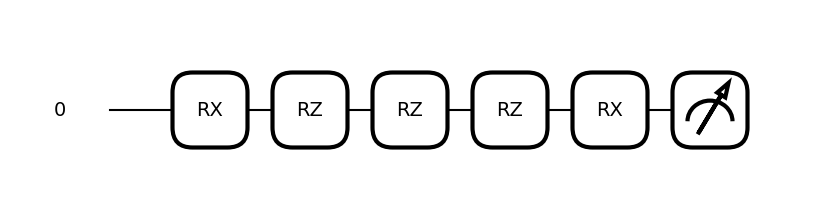

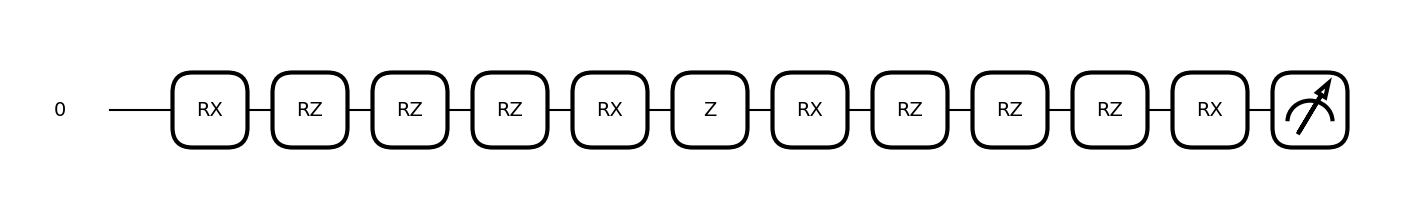

In [10]:
import pennylane as qml
import numpy as np

dim_x = 1
dim_alpha = 2
observable_terms = ['Z0']

def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def U(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RZ(α[1], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[0], wires=0)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RZ(α[1], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[0], wires=0)
    P = build_P(observable_terms)
    qml.RX(-x[0], wires=0)
    qml.RZ(-α[0], wires=0)
    qml.RZ(-α[1], wires=0)
    qml.RZ(-α[0], wires=0)
    qml.RX(-x[0], wires=0)
    return qml.state()

x0 = np.zeros(dim_x)
α0 = np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0);
qml.draw_mpl(UPU)(x0, α0);


## Rz(alpha)Rz(-alpha)Rz(alpha) part 2 output

(0, 0)
  total shots:     10000
  kept shots:      10000
  fraction kept:   1.000000
  expectation:     1.0

(0, 1)
  total shots:     10000
  kept shots:      6937
  fraction kept:   0.693700
  expectation:     0.19475277497477295

(0, 2)
  total shots:     10000
  kept shots:      7089
  fraction kept:   0.708900
  expectation:     0.8171815488785442

(1, 0)
  total shots:     10000
  kept shots:      7008
  fraction kept:   0.700800
  expectation:     0.18864155251141554

(1, 1)
  total shots:     10000
  kept shots:      3979
  fraction kept:   0.397900
  expectation:     1.0

(1, 2)
  total shots:     10000
  kept shots:      4178
  fraction kept:   0.417800
  expectation:     0.6160842508377214

(2, 0)
  total shots:     10000
  kept shots:      7144
  fraction kept:   0.714400
  expectation:     0.8197088465845465

(2, 1)
  total shots:     10000
  kept shots:      4123
  fraction kept:   0.412300
  expectation:     0.6182391462527286

(2, 2)
  total shots:     10000
  kept shot

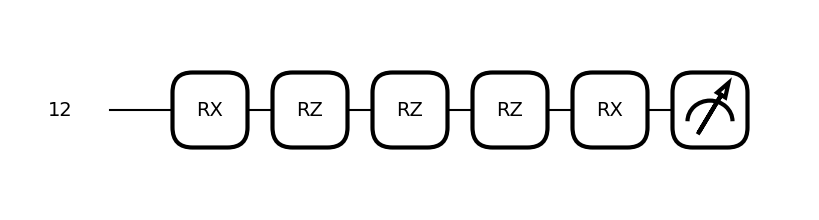

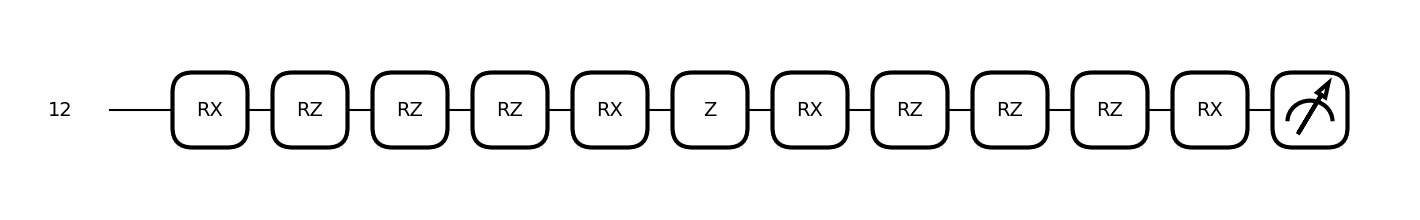

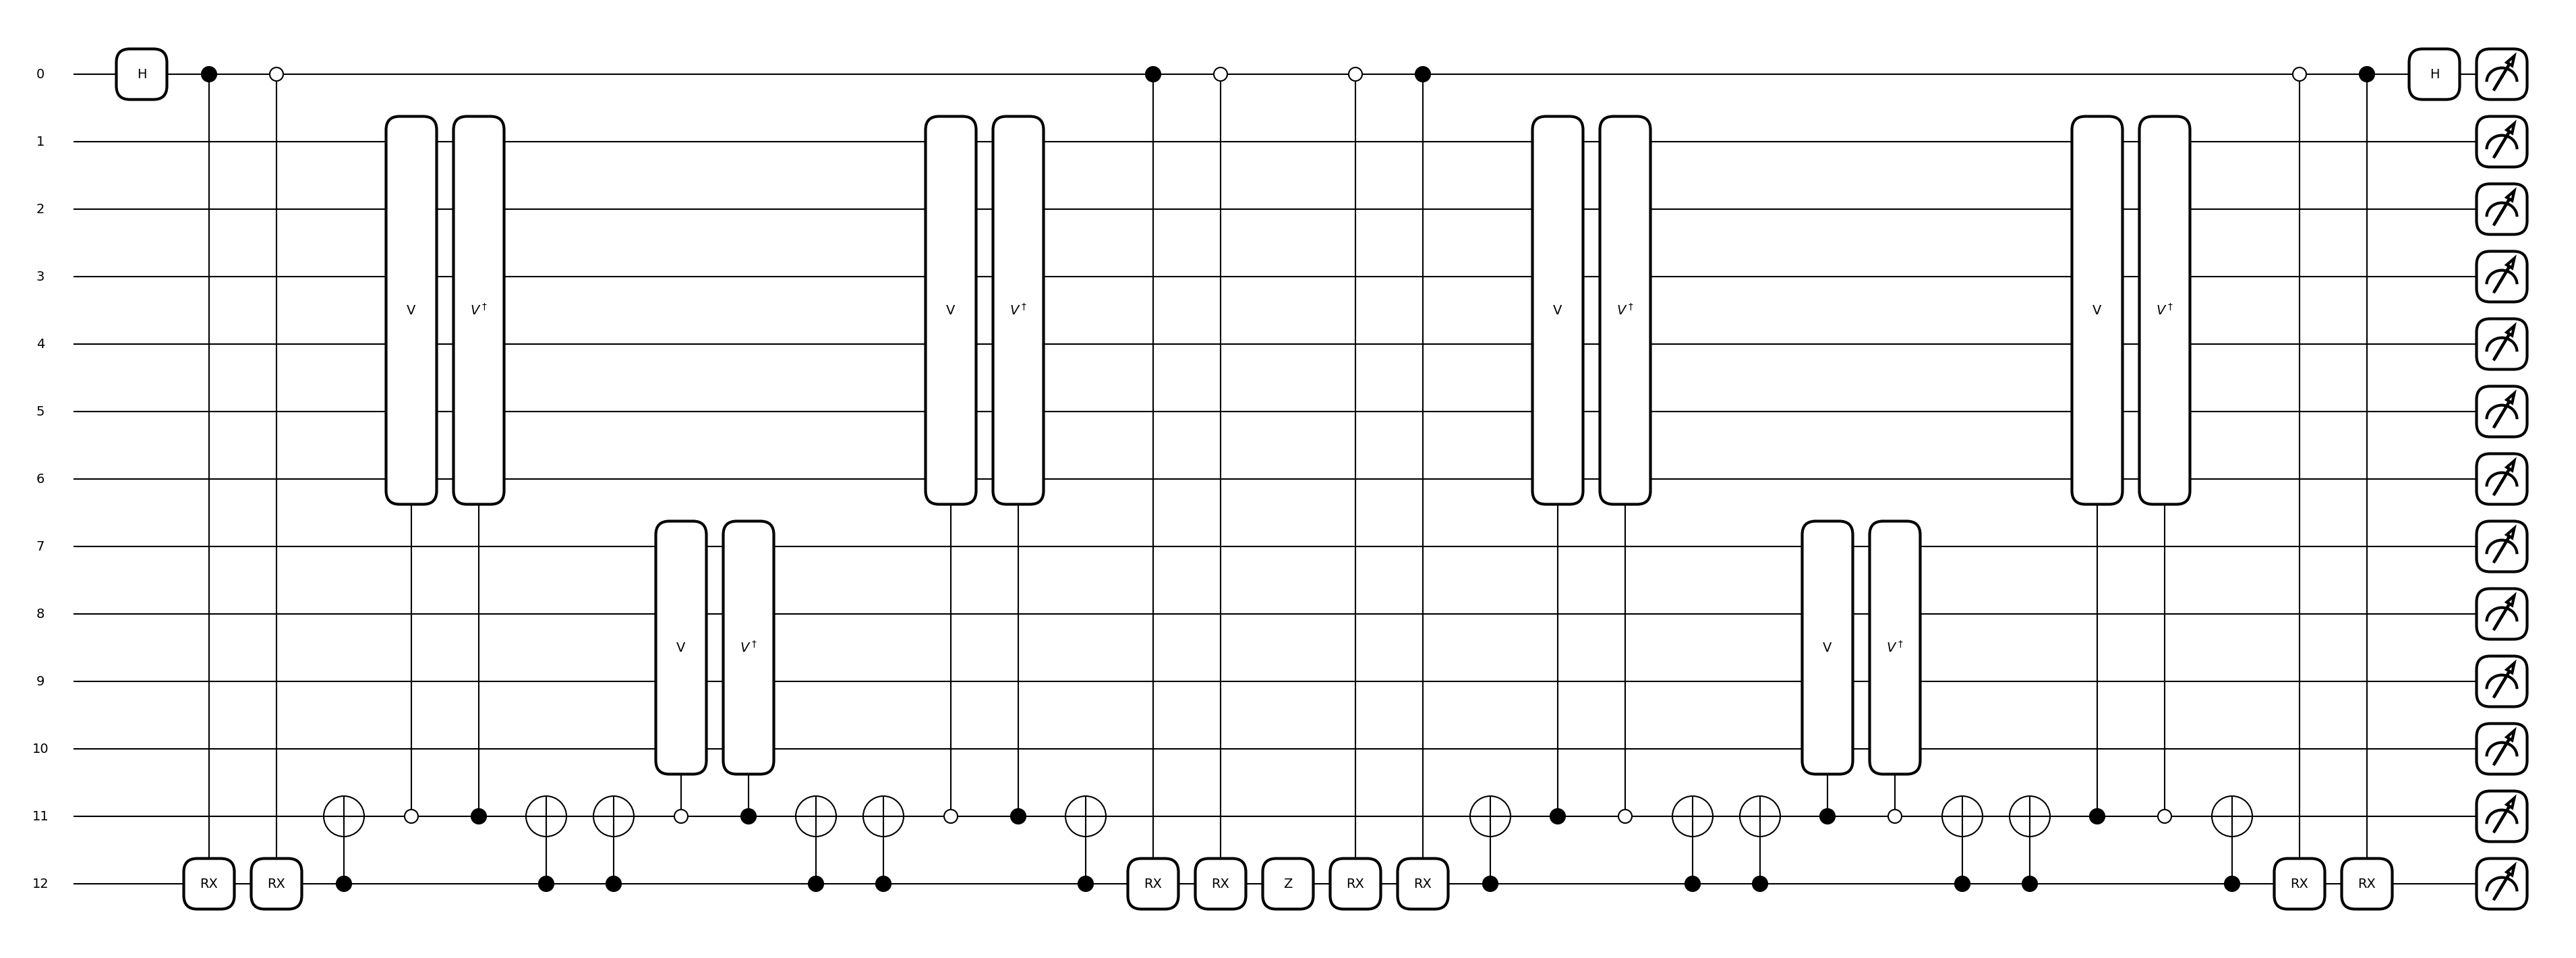

In [6]:
import pennylane as qml
import numpy as np


# Wrapper gates for controlled Adders
class V(qml.operation.Operation):
    num_params = 2
    par_domain = "R"
    def __init__(self, value, wires, mod):
        super().__init__(value, mod, wires=wires)


    def decomposition(self):
        # Actual gate: controlled Adder
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]

# Adjoint version
class Vdagger(V):
    def __name__(self):
        return "V†"

    def decomposition(self):
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]
Vdagger.__name__ = r"$V^\dagger$"

dim_x=1
dim_alpha=2
observable_terms=['Z0']

# build_P function
def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

n_kernel=1; freq_register_sizes={0: 6, 1: 4}; n_freq=10
n_anc=1; n_circ=1; n_total=13
kernel_offset=0; freq_offset=1
anc_offset=11; circ_offset=12
shots = 10000

dev=qml.device('default.qubit', wires=n_total, shots = shots)

@qml.qnode(dev)
def U(x, α):
    qml.RX(x[0], wires=12)
    qml.RZ(α[0], wires=12)
    qml.RZ(α[1], wires=12)
    qml.RZ(α[0], wires=12)
    qml.RX(x[0], wires=12)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=12)
    qml.RZ(α[0], wires=12)
    qml.RZ(α[1], wires=12)
    qml.RZ(α[0], wires=12)
    qml.RX(x[0], wires=12)
    # build P on shifted observables
    shifted_terms=[]
    for term in observable_terms:
        parts=term.replace('+',' ').split()
        new_parts=[]
        for p in parts:
            op=p[0].upper()
            idx=int(p[1:])
            new_parts.append(f'{op}{idx+12}')
        shifted_terms.append(' '.join(new_parts))
    P=build_P(shifted_terms)
    # user-provided adjoint (trimmed prefix)
    qml.RX(-x[0], wires=12)
    qml.RZ(-α[0], wires=12)
    qml.RZ(-α[1], wires=12)
    qml.RZ(-α[0], wires=12)
    qml.RX(-x[0], wires=12)
    return qml.state()

def AuPAu(x, x1, α):
    qml.Hadamard(wires=0)

    qml.ctrl(qml.RX, control=0, control_values=[1])(x[0], wires=12)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[0], wires=12)
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [0])( value = 1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.ctrl(Vdagger, control = 11, control_values = [1])( value = -1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.CNOT(wires=(12,11))
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [0])( value = 1, wires=[7, 8, 9, 10], mod=2**4)
    qml.ctrl(Vdagger, control = 11, control_values = [1])( value = -1, wires=[7, 8, 9, 10], mod=2**4)
    qml.CNOT(wires=(12,11))
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [0])( value = 1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.ctrl(Vdagger, control = 11, control_values = [1])( value = -1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.CNOT(wires=(12,11))
    qml.ctrl(qml.RX, control=0, control_values=[1])(x[0], wires=12)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[0], wires=12)

    shifted_terms=[]
    for term in observable_terms:
        parts=term.replace('+',' ').split()
        new_parts=[]
        for p in parts:
            op=p[0].upper()
            idx=int(p[1:])
            new_parts.append(f'{op}{idx+12}')
        shifted_terms.append(' '.join(new_parts))
    P=build_P(shifted_terms)

    # Adjoint – reverse of duplicated U
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[0], wires=12)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[0], wires=12)
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [1])( value = 1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.ctrl(Vdagger, control = 11, control_values = [0])( value = -1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.CNOT(wires=(12,11))
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [1])( value = 1, wires=[7, 8, 9, 10], mod=2**4)
    qml.ctrl(Vdagger, control = 11, control_values = [0])( value = -1, wires=[7, 8, 9, 10], mod=2**4)
    qml.CNOT(wires=(12,11))
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [1])( value = 1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.ctrl(Vdagger, control = 11, control_values = [0])( value = -1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.CNOT(wires=(12,11))
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[0], wires=12)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[0], wires=12)
    qml.Hadamard(wires=0)


@qml.qnode(dev)
def AuPAu_sample(x, x1, α):
    AuPAu(x, x1, α)   # run your circuit
    return qml.sample(wires=range(n_total))


# Example caller
x0=np.zeros(dim_x); x1=np.copy(x0); α0=np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0); qml.draw_mpl(UPU)(x0, α0); qml.draw_mpl(AuPAu_sample)(x0, x1, α0);


def conditional_Z_kernel(x, x1, α):
    # shots = 10000
    samples = AuPAu_sample(x, x1, α)

    # Extract each register
    kernel = samples[:, kernel_offset]     # wire 0
    anc = samples[:, anc_offset]           # wire 4
    circ = samples[:, circ_offset]         # wire 5

    # Condition: anc=0 and circ=0
    mask = (anc == 0) & (circ == 0)
    conditioned = kernel[mask]

    total = shots
    kept = conditioned.shape[0]

    if kept == 0:
        return {
            "total_shots": total,
            "kept_shots": 0,
            "expectation": None,
        }

    # convert bits to Z eigenvalues (+1 for 0, -1 for 1)
    zvals = 1 - 2*conditioned       # maps 0→+1, 1→−1

    return {
        "total_shots": total,
        "kept_shots": kept,
        "fraction_kept": kept / total,
        "expectation": np.mean(zvals),
    }

def compute_kernel_matrix(X, α):
    n = len(X)
    K = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            res = conditional_Z_kernel(X[i], X[j], α)

            # Store expectation (or 0 if no successful post-selection)
            K[i, j] = res["expectation"] if res["expectation"] is not None else 0.0

            # Print diagnostics
            print(f"({i}, {j})")
            print(f"  total shots:     {res['total_shots']}")
            print(f"  kept shots:      {res['kept_shots']}")
            print(f"  fraction kept:   {res['fraction_kept']:.6f}")
            print(f"  expectation:     {res['expectation']}")
            print()
    return K

X = [np.array([0.0]), np.array([1.2]), np.array([-0.7])]
α = np.array([0.5])

K = compute_kernel_matrix(X, α)
print(K)

def kernel_b_norm(x, x1):
    num = 2*(np.cos(x)**2 * np.cos(x1)**2 + 0.5 * np.sin(x)**2 * np.sin(x1)**2)
    denom = np.cos(x)**4 + np.cos(x1)**4 +0.5*(np.sin(x)**4 + np.sin(x1)**4)
    return num / denom

X = [0.0, 1.2, -0.7]
n = len(X)
K2 = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        K2[i, j] = kernel_b_norm(X[i], X[j])

print("Theory Normalized kernel matrix:")
print(K2)
